<a href="https://colab.research.google.com/github/rs-delve/tti-explorer/blob/master/notebooks/tti-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TTI Strategies

All of the information about the primary case's infection and how they infect their social contacts (under no government intervention) is now contained in `primary_case` and `social_contacts`.

Now we run a simulation, which works as follows. We start by generating a large number of cases, each with associated contacts. Given a particular strategy (e.g. test-based TTI with NPI of stringency level S3), each case is passed through the strategy, which computes various metrics for the case. For example, it computes the number of secondary cases due to primary case (reproduction number) and the number of tests required. We then collect the results for each case and average them, returning the final evaluation of the strategy.

## Running a Simulation

In [1]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

%pip install pyDOE
%pip install emukit
%pip install gpy
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/teaching_plots.py','teaching_plots.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/mlai.py','mlai.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/gp_tutorial.py','gp_tutorial.py')


from matplotlib import colors as mcolors
from matplotlib import cm
import numpy as np
import GPy
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
import matplotlib.pyplot as pltb
import teaching_plots as plot
import mlai
import pandas as pd

fatal: destination path 'tti-explorer' already exists and is not an empty directory.
/Users/milliemcquillin/Desktop/MPhil/ML & PW/project/tti-le48/tti-explorer-with-changes/notebooks/millie/tti-explorer
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We will analyse the `S3_test_based_TTI` strategy from our report. For clarity, we will show the whole process.

In [2]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

First get the configurations:

In [3]:
name = 'S3_test_based_TTI'

case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", name)[name]

print(policy_config)

{'isolate_individual_on_symptoms': True, 'isolate_individual_on_positive': True, 'isolate_household_on_symptoms': True, 'isolate_household_on_positive': True, 'isolate_contacts_on_symptoms': False, 'isolate_contacts_on_positive': True, 'test_contacts_on_positive': False, 'do_symptom_testing': True, 'do_manual_tracing': True, 'do_app_tracing': True, 'fractional_infections': True, 'testing_delay': 2, 'app_trace_delay': 0, 'manual_trace_delay': 1, 'manual_home_trace_prob': 1.0, 'manual_work_trace_prob': 1.0, 'manual_othr_trace_prob': 1.0, 'met_before_w': 0.79, 'met_before_s': 0.9, 'met_before_o': 0.9, 'max_contacts': 10, 'quarantine_length': 14, 'latent_period': 3, 'app_cov': 0.35, 'compliance': 0.8, 'go_to_school_prob': 0.5, 'wfh_prob': 0.45}


In [4]:
from scipy.stats import gamma


def update_case_config(p_day_noticed_symptoms_ab, inf_profile_ab):
    alpha = [p_day_noticed_symptoms_ab[0], inf_profile_ab[0]]
    beta = [p_day_noticed_symptoms_ab[1], inf_profile_ab[1]]
    strs = ['p_day_noticed_symptoms', 'inf_profile']
    
    for i in range(2):
    
        x = np.linspace(gamma.pdf(0.01, a=alpha[i], scale=1/beta[i]),
                        gamma.pdf(0.99, a=alpha[i], scale=1/beta[i]), 10)

        #apply softmax
        norm = np.exp(x)
        s = sum(norm)
        norm = np.round(norm/s, decimals=2)
        norm[-1] = 1- sum(norm[:-1])

        case_config[strs[i]] = norm
    
    return case_config



def update_policy_config(compliance, app_cov, latent_var):
    policy_config['compliance'] = compliance
    policy_config['app_cov'] = app_cov
    policy_config['latent_period'] = int(latent_var)
    
    return policy_config





In [5]:
# Separating this because it is built from the ammended policy_config

factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

Set a random state:

In [6]:
rng = np.random.RandomState(42)

Make contact simulator:

In [7]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

Make the TTI Model:

In [8]:
tti_model = TTIFlowModel(rng, **strategy_config)

Generate cases, contacts and run simulation:

In [9]:
"""
Runs TTI simulator as many times as the different input initialisations.
The main reason we need this is to put in to EmuKit for the Experimental
Design Loop.

Args:
    pol_configs (list): Inputs are [app_cov, compliance]

Returns:
    effective_rs (np.expand_dims(np.array(to_return), 1)): For every simulation run, return
    the effective r, as was plotted form Bryn and Andrei previously.

"""
rng = np.random.RandomState(42)
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

def run_tti_sim(pol_configs):
    to_return=[]
    for vals in pol_configs:

        policy_config = update_policy_config(vals[0], vals[1], vals[2])
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
        tti_model = TTIFlowModel(rng, **strategy_config)
        n_cases = 10000
        outputs = list()
        temp =[]
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
        to_return.append(np.mean(temp))
    return np.expand_dims(np.array(to_return), 1)


In [10]:
compliance_domain = [0, 0.99] 
app_cov_domain = [0, 0.99]
latent_domain = [1,6] 

# Set variables range. Since we are dealing with percentages (app_cov, compliance)
# [0.05, 1] should do.
initial_samples = 5 # number of random runs to perform before starting experimental design 
space = ParameterSpace([ContinuousParameter('compliance', *compliance_domain),
                        ContinuousParameter('app_cov', *app_cov_domain),
                        ContinuousParameter('latent_period', *latent_domain)]) # init param space for experimental design
design = RandomDesign(space)
x = design.get_samples(initial_samples) # get 5 random combinations of initialisations

print(x)
y = run_tti_sim(x) # obtain corresponding effective_rs

[[0.90412345 0.17927743 2.49574645]
 [0.90452057 0.28586159 2.03365154]
 [0.85744221 0.48432861 2.04927833]
 [0.59899913 0.46989081 1.84098894]
 [0.56664321 0.81566458 4.30645218]]


In [11]:
# Fitting emulator to data, x: (app_cov, compliance), y: effective_r
Num_of_param = 3
kern_eq = GPy.kern.RBF(input_dim=Num_of_param, ARD = True)
kern_bias = GPy.kern.Bias(input_dim=Num_of_param)
kern = kern_eq + kern_bias
model_gpy = GPRegression(x,y, kern)
model_gpy.kern.variance = 1**2
model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy) 
model_emukit.optimize() # optimise (max log-lik)
display(model_gpy)



Optimization restart 1/1, f = -0.6431878420638042


GP_regression.,value,constraints,priors
sum.rbf.variance,3.3679638511789802,+ve,
sum.rbf.lengthscale,"(3,)",+ve,
sum.bias.variance,3.0623352240928746e-10,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [12]:
# Initialise experimental design loop. Using integrated variance as acquisition
# to "query" the input space aiming to reduce uncertainty over the func we're approx. i.e. effective_r
num_of_loops = 50
integrated_variance = IntegratedVarianceReduction(space=space, model=model_emukit)
ed = ExperimentalDesignLoop(space=space, model=model_emukit, acquisition = integrated_variance)
ed.run_loop(run_tti_sim, num_of_loops)

Optimization restart 1/1, f = -0.6431878420638042



Optimization restart 1/1, f = -0.22655415572027637



Optimization restart 1/1, f = -1.318561558926774



Optimization restart 1/1, f = -1.6545120962876112



Optimization restart 1/1, f = -4.243032629084866



Optimization restart 1/1, f = -4.49989568447492



Optimization restart 1/1, f = -6.1059798039351065


 /Users/milliemcquillin/opt/anaconda3/envs/ml-pw-init/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



Optimization restart 1/1, f = 2.592497798191358



Optimization restart 1/1, f = 4.428859838114471



Optimization restart 1/1, f = 3.7228172774644106



Optimization restart 1/1, f = 2.2725296881681505



Optimization restart 1/1, f = 2.9485479687927025



Optimization restart 1/1, f = 3.717156837110414



Optimization restart 1/1, f = 3.5118687903798467



Optimization restart 1/1, f = 5.779873312952969



Optimization restart 1/1, f = 8.601744212409475



Optimization restart 1/1, f = 7.734546881197936



Optimization restart 1/1, f = 14.699030114260523



Optimization restart 1/1, f = 14.276208047701116



Optimization restart 1/1, f = 13.576607102533682



Optimization restart 1/1, f = 12.545059176704758



Optimization restart 1/1, f = 11.12283882518704



Optimization restart 1/1, f = 11.645659974449064



Optimization restart 1/1, f = 10.018482863865746



Optimization restart 1/1, f = 10.228163181605037



Optimization restart 1/1, f = 9.05429086124235



Optimization restart 1/1, f = 9.29030331370392



Optimization restart 1/1, f = 7.9267358655853



Optimization restart 1/1, f = 10.730822544069504



Optimization restart 1/1, f = 10.236270882371407



Optimization restart 1/1, f = 9.107321746007166



Optimization restart 1/1, f = 13.454720602649104



Optimization restart 1/1, f = 14.413747951741406



Optimization restart 1/1, f = 13.020237658808092



Optimization restart 1/1, f = 11.750992475733995



Optimization restart 1/1, f = 9.523855254105818



Optimization restart 1/1, f = 9.547978978562881



Optimization restart 1/1, f = 8.032732896627579



Optimization restart 1/1, f = 9.819989824244871



Optimization restart 1/1, f = 14.382251465787402



Optimization restart 1/1, f = 12.398528738304016



Optimization restart 1/1, f = 11.065140303667533



Optimization restart 1/1, f = 10.259731181298935



Optimization restart 1/1, f = 8.956706955225858



Optimization restart 1/1, f = 11.3113294626855



Optimization restart 1/1, f = 10.085799489191988



Optimization restart 1/1, f = 14.532885803714606



Optimization restart 1/1, f = 14.338212784591029



Optimization restart 1/1, f = 14.369862536598134



Optimization restart 1/1, f = 15.866233472609014



Optimization restart 1/1, f = 14.357248798350955


main_effects:  {'compliance': array([0.9498053]), 'app_cov': array([0.03543105]), 'latent_period': array([0.02474952])}
total_effects:  {'compliance': array([0.96357976]), 'app_cov': array([-0.02183634]), 'latent_period': array([-0.07585179])}


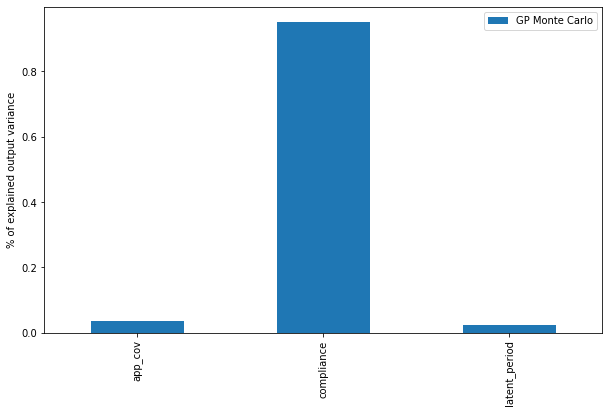

In [13]:
# Plot Main Effects

num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)
print("main_effects: ", main_effects_gp)
print("total_effects: ", total_effects_gp)


fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

mlai.write_figure(filename='first-order-sobol-indices-gp-catapult.svg', directory='./uq')

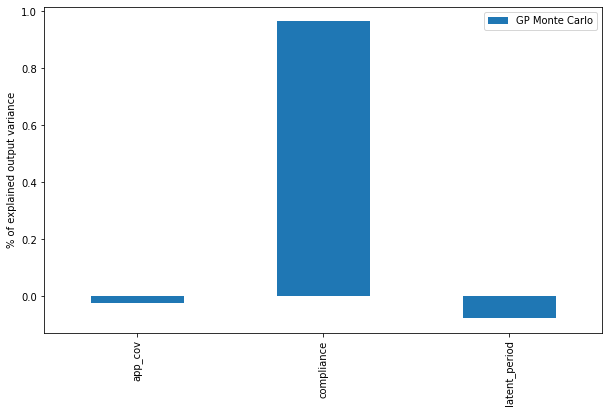

In [14]:
# Plot Total Effects

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

mlai.write_figure(filename='total-effects-sobol-indices-gp-catapult.svg', directory='./uq')

In [15]:
app_cov_eval = np.linspace(0.05, 1, 100)
app_com_eval = np.linspace(0.05, 1, 100)
points=[]
for i in app_cov_eval:
    for j in app_com_eval:
        points.append([i, j])
points = np.asarray(points)

X = points[:,0].reshape((100,100))
Y = points[:,1].reshape((100,100))
Z, _ = model_gpy.predict(points)
Z = Z.reshape((100,100))

print(X.shape)
print(Y.shape)
print(Z.shape)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.7)
# ax.scatter(x[:,0], x[:,1], y, color='red', alpha=0.99)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2